<a href="https://colab.research.google.com/github/jakeoung/ShapeFromProjections/blob/master/ctdr_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to simulate projections from an obj file.

To run the code, you need to enable the CUDA in the setting. You can enable in the menu: `Runtime > Change runtime type` and choose GPU in the hardware accelerator item.

In [ ]:
# install shapefromprojections package a
%cd /content
!git clone https://github.com/jakeoung/ShapeFromProjections
%cd ShapeFromProjections
!pip install -e .
import sys
import os
sys.path.append(os.getcwd())

In [ ]:
# install CUDA kernels
%cd ctdr/cuda
!python build.py build_ext --inplace
%cd ../../run

In [29]:
# Make a data folder 
# 2testA: the number of materials is 2 and A means the simple type of homogeneous material
ddata = "../data/2testA/"
!mkdir $ddata
ftoml = f"{ddata}/proj_geom.toml"
nangles = 30
with open(ftoml, "w") as target:
    target.write('''type = "parallel3d"
ProjectionAngles = [
    0.0, 0.10471975511965978, 0.20943951023931956, 0.3141592653589793, 0.4188790204786391, 0.5235987755982988, 0.6283185307179586, 0.7330382858376184, 0.8377580409572782, 0.9424777960769379, 1.0471975511965976, 1.1519173063162575, 1.2566370614359172, 1.361356816555577, 1.4660765716752369, 1.5707963267948966, 1.6755160819145565, 1.7802358370342162, 1.8849555921538759, 1.9896753472735358, 2.0943951023931953, 2.199114857512855, 2.303834612632515, 2.4085543677521746, 2.5132741228718345, 2.6179938779914944, 2.722713633111154, 2.827433388230814, 2.9321531433504737, 3.036872898470133]
DetectorRowCount = 192
DetectorColCount = 192
DetectorSpacingX = 0.01041666666666667
DetectorSpacingY = 0.01041666666666667''')
    
import toml
proj_geom = toml.load(ftoml)

mkdir: cannot create directory ‘../data/2testA/’: File exists


In [73]:
# Download an example watertight obj file
!wget https://groups.csail.mit.edu/graphics/classes/6.837/F03/models/teddy.obj
!mv teddy.obj ../data/2testA/init.obj

--2021-05-26 20:00:50--  https://groups.csail.mit.edu/graphics/classes/6.837/F03/models/teddy.obj
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91538 (89K)
Saving to: ‘teddy.obj’

teddy.obj           100%[===================>]  89.39K  --.-KB/s    in 0.1s    

2021-05-26 20:00:50 (628 KB/s) - ‘teddy.obj’ saved [91538/91538]



In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import h5py
import time

import ctdr
from ctdr.model.vanilla import Model
from ctdr.utils import util_mesh
from ctdr import optimize
import subprocess
import toml
 
nmaterials = 2
finit_obj = ddata+'/init.obj'
mus = [0.0, 1.0]  # attentuation coefficient

model = Model(finit_obj, proj_geom, nmaterials,
              mus, 0, 0.0, 0.0).cuda()

# (optional) Since the obj file is not normalized to -1 ~ 1, I normalize
# Please check the projection geometry above

def normalize(a):
    a = (a - a.min()) / (a.max() - a.min()) * 1.8 - 0.9
    return a

model.vertices[:,0] = normalize(model.vertices[:,0])
model.vertices[:,1] = normalize(model.vertices[:,1])
model.vertices[:,2] = normalize(model.vertices[:,2])

@statistics of mesh: # of v: 1598, f: 3192
set mu as parameters


In [75]:
# Generate projections
out = model(torch.arange(nangles), 0.0)
proj = out[0].detach().cpu().numpy() # [nangles x height x width]

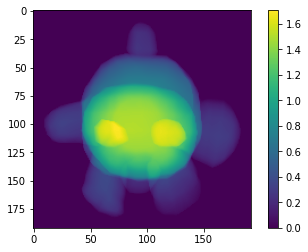

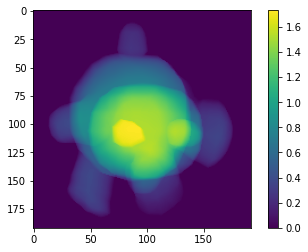

In [78]:
# Show the projection image
# For non-manifold obj file, there can be some artifacts
plt.imshow(proj[0,:,:]); plt.colorbar(); plt.show()
plt.imshow(proj[2,:,:]); plt.colorbar(); plt.show()